# Heterogeneous Treatment Effects in Advertising: A Post-Hoc Segmentation Approach

## Introduction

In the realm of digital advertising, one size rarely fits all. Users respond differently to campaigns based on their individual characteristics and preferences. This project aims to uncover these nuanced responses by segmenting users and quantifying the heterogeneous treatment effects of a marketing campaign on user engagement (visits and conversions). By identifying which groups of users are most responsive, we can inform targeted advertising strategies and optimize resource allocation for maximum impact.

## Methodology

This project employs a data-driven approach to discover hidden patterns and individualize campaign effectiveness:

*   **Correlation Analysis**: We begin by examining the correlation between user features to understand potential redundancies or relationships among variables.

*   **Principal Component Analysis (PCA)**: We use PCA to reduce the dimensionality of the feature space, making it easier to visualize and interpret the data. This technique helps us capture the most important information while minimizing noise.

*   **Clustering Analysis**: Clustering algorithms are applied to the principal components to identify distinct groups of users with similar characteristics and behavioral patterns. This segmentation is crucial for understanding how different types of users respond to the ad campaign.

*   **Logistic Regression with Bootstrapping**: We employ logistic regression models to estimate the average treatment effect on the treated (ATT) within each cluster. Bootstrapping provides robust confidence intervals for these estimates, accounting for the uncertainty inherent in observational data.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf
from matplotlib.colors import LinearSegmentedColormap
from math import pi

In [2]:
# Load data
matched_data = pd.read_csv('/content/drive/MyDrive/datasets/matched_data.csv')
matched_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,propensity_score
0,12.896938,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1,0.025425
1,16.689925,10.059654,8.214383,1.267425,10.280525,4.115453,-6.699321,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1,0.036953
2,12.781566,10.059654,8.215920,1.114982,11.561050,4.115453,-7.011752,4.833815,3.799079,45.054671,5.303177,-0.337358,1,1,1,1,0.204294
3,13.018571,10.059654,8.301697,-0.413110,10.280525,4.115453,-10.143546,4.833815,3.876391,30.796373,5.300375,-0.168679,1,0,1,1,0.205899
4,12.704505,10.059654,8.214383,0.604065,10.280525,4.115453,-8.058865,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1,0.090552


## Correlation Analysis

First, we'll examine the correlation between the features to understand potential redundancies or relationships among the variables.

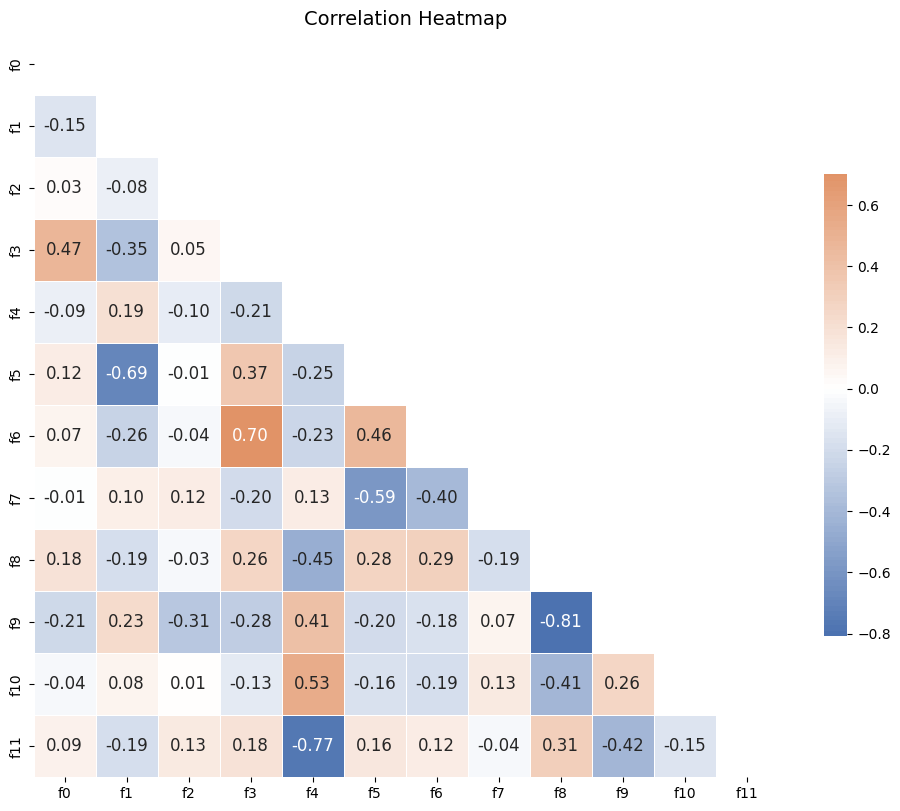

In [3]:
# Retrieve the "deep" palette colors
deep_colors = sns.color_palette("deep")

# Convert the Seaborn palette to a list of hex colors
deep_colors_hex = deep_colors.as_hex()

# Set the custom color palette in Matplotlib's rcParams
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=deep_colors_hex)

# Define features
features = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']

# Create a custom colormap using the first two colors from the "deep" palette
cmap_colors = [deep_colors_hex[0], "white", deep_colors_hex[1]]
cmap = LinearSegmentedColormap.from_list(name='custom_coolwarm', colors=cmap_colors, N=100)

# Calculate the correlation matrix, excluding non-numeric columns
corr_matrix = matched_data[features].corr()

# Generate a mask for the upper triangle to avoid redundant information
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot correlation heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"size": 12}, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The correlation heatmap reveals several interesting relationships among the features, including **strong positive correlations (e.g., f3 and f6)**, **strong negative correlations (e.g., f4 and f11)**, and moderate correlations. These relationships suggest potential redundancies and provide insights into how different features might interact to influence user behavior.

## Principal Component Analysis (PCA)

We will use PCA to reduce the dimensionality of our feature space while preserving the most important information. This will help us visualize the data and potentially identify clusters of similar users.

In [4]:
# Selecting the features from matched_data
data_for_pca = matched_data[features]

# Create a PCA pipeline
pca_pipeline = make_pipeline(StandardScaler(), PCA())
pca_results = pca_pipeline.fit_transform(data_for_pca)

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(pca_results, columns=[f'PC{i+1}' for i in range(len(features))])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-1.986786,0.430113,-1.031356,0.685547,0.505866,0.230097,-0.301074,1.352726,0.113506,0.039289,0.008960,-0.047928
1,-1.681315,0.038535,-0.723378,0.724622,0.528737,-0.670969,-0.415068,0.401765,-0.273535,0.318398,0.013650,-0.093925
2,1.473397,2.595875,-1.253766,0.287694,0.315860,0.104280,1.341468,0.220069,-0.151585,-0.081971,-0.272275,-0.045486
3,-0.183199,0.260488,-1.550543,-0.483736,-0.176217,-0.235014,0.076008,0.103614,-0.179896,0.165811,-0.047188,0.177570
4,-1.338211,-0.179957,-1.420296,0.216912,0.830791,-0.452354,-0.398601,0.881904,-0.008499,0.107158,0.009715,-0.055953


In [5]:
# Explained variance and cumulative explained variance
explained_variance = pca_pipeline.named_steps['pca'].explained_variance_
cumulative_explained_variance = np.cumsum(pca_pipeline.named_steps['pca'].explained_variance_ratio_) * 100

### Scree Plot

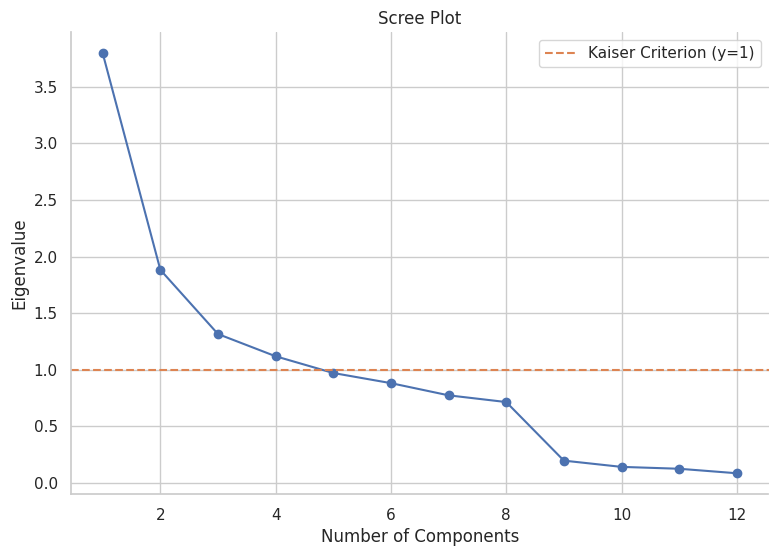

In [6]:
# Plotting Scree Plot
plt.figure(figsize=(9, 6))
sns.set(style="whitegrid")
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color=deep_colors_hex[0])
plt.axhline(1, color=deep_colors_hex[1], linestyle='dashed', label='Kaiser Criterion (y=1)')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
sns.despine()
plt.legend()
plt.show()

### Cumulative Explained Variance Plot

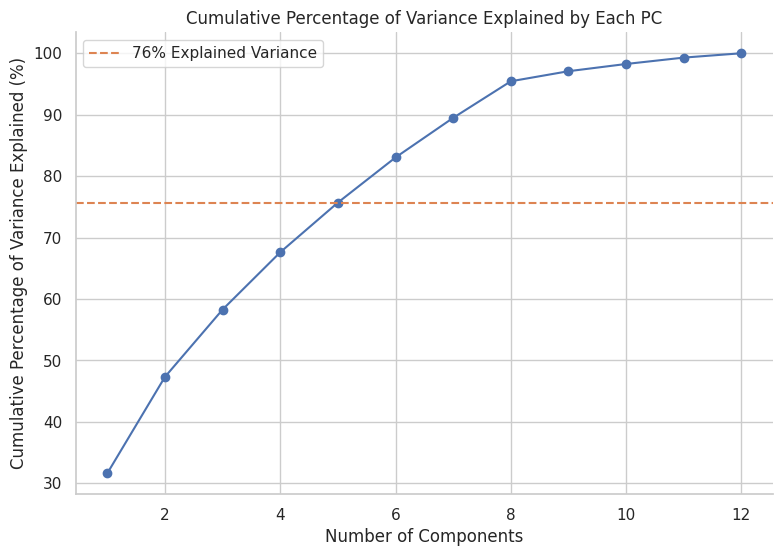

In [7]:
# Plotting Cumulative Explained Variance Plot
plt.figure(figsize=(9, 6))
sns.set(style="whitegrid")
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color=deep_colors_hex[0])
plt.axhline(75.7, color=deep_colors_hex[1], linestyle='dashed', label='76% Explained Variance')
plt.title('Cumulative Percentage of Variance Explained by Each PC')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Percentage of Variance Explained (%)')
sns.despine()
plt.legend()
plt.show()

The scree plot and cumulative variance plot guide us to retain the **first five principal components, which capture a substantial portion (over 76%) of the total variance in the data**. This dimensionality reduction allows for a more parsimonious representation of the data while retaining its most salient features.

## Clustering Analysis for Segmentation

We will apply clustering to the principal components to identify distinct segments of users.



### Determining Optimal Number of Clusters

We'll use two methods to determine the optimal number of clusters:

*   **Elbow Method**: Looks for a "kink" in the sum of squared errors (SSE) as the number of clusters increases.

Processed k=2
Processed k=3
Processed k=4
Processed k=5
Processed k=6
Processed k=7
Processed k=8
Processed k=9
Processed k=10


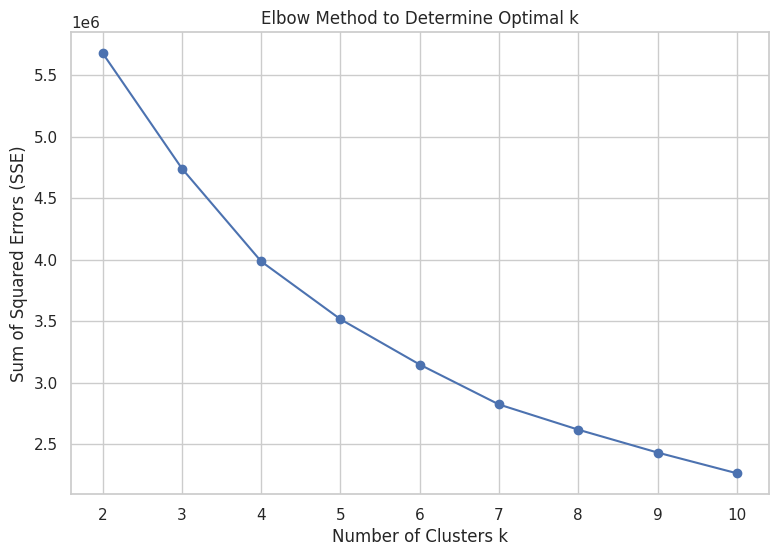

In [8]:
# Prepare the data
X = matched_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Calculate SSE for a range of k values
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)
    print(f"Processed k={k}")

# Plot SSE to find the elbow
plt.figure(figsize=(9, 6))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters k')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

*   **Silhouette Analysis**: Measures how similar an object is to its own cluster compared to other clusters. Higher silhouette scores indicate better-defined clusters.



For k=2, silhouette score is 0.3308
For k=3, silhouette score is 0.3107
For k=4, silhouette score is 0.2663
For k=5, silhouette score is 0.2528
For k=6, silhouette score is 0.2341
For k=7, silhouette score is 0.2591
For k=8, silhouette score is 0.2473
For k=9, silhouette score is 0.2523
For k=10, silhouette score is 0.2633


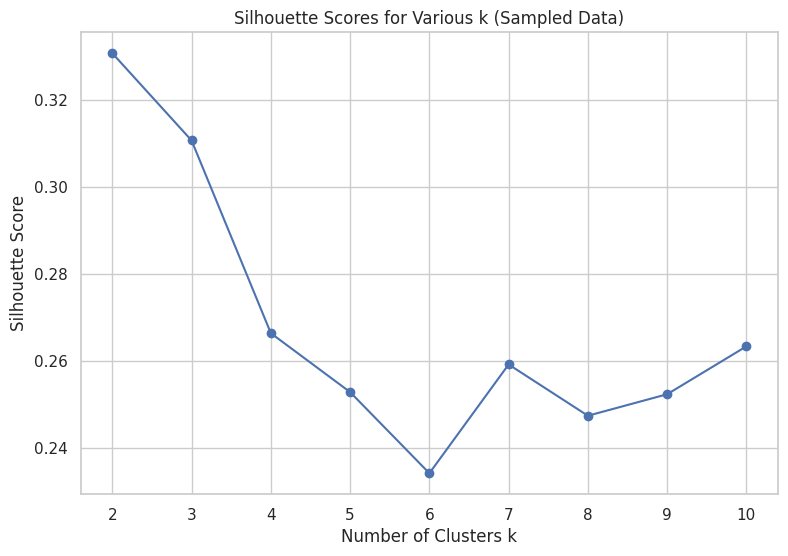

In [9]:
# Sampling the data for silhouette analysis
sample_X = resample(X_pca, n_samples=10000, random_state=0, replace=False)

# Compute silhouette scores for the selected range
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(sample_X)
    score = silhouette_score(sample_X, labels)
    silhouette_scores.append(score)
    print(f"For k={k}, silhouette score is {score:.4f}")

# Plotting silhouette scores
plt.figure(figsize=(9, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various k (Sampled Data)')
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhouette Score')
plt.show()

The Elbow method and Silhouette Analysis both suggest that **4 clusters** is the optimal number of clusters for this dataset.

### KMeans Clustering

Let's apply K-Means clustering to the selected principal components to divide our users into distinct groups.

In [10]:
# Fit KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
kmeans.fit(X_pca)

# Assign clusters back to the original data
matched_data['cluster'] = kmeans.labels_ + 1

The K-means algorithm has assigned each user in our dataset to one of four distinct clusters based on their similarity in the PCA space. This segmentation is a critical step in understanding the heterogeneity of treatment effects, as we can now examine how the impact of the ad campaign varies across these different groups.

### Visualizing Clusters in PCA Space

To better understand the characteristics of each cluster, we'll visualize their distribution across the first five principal components using box plots.

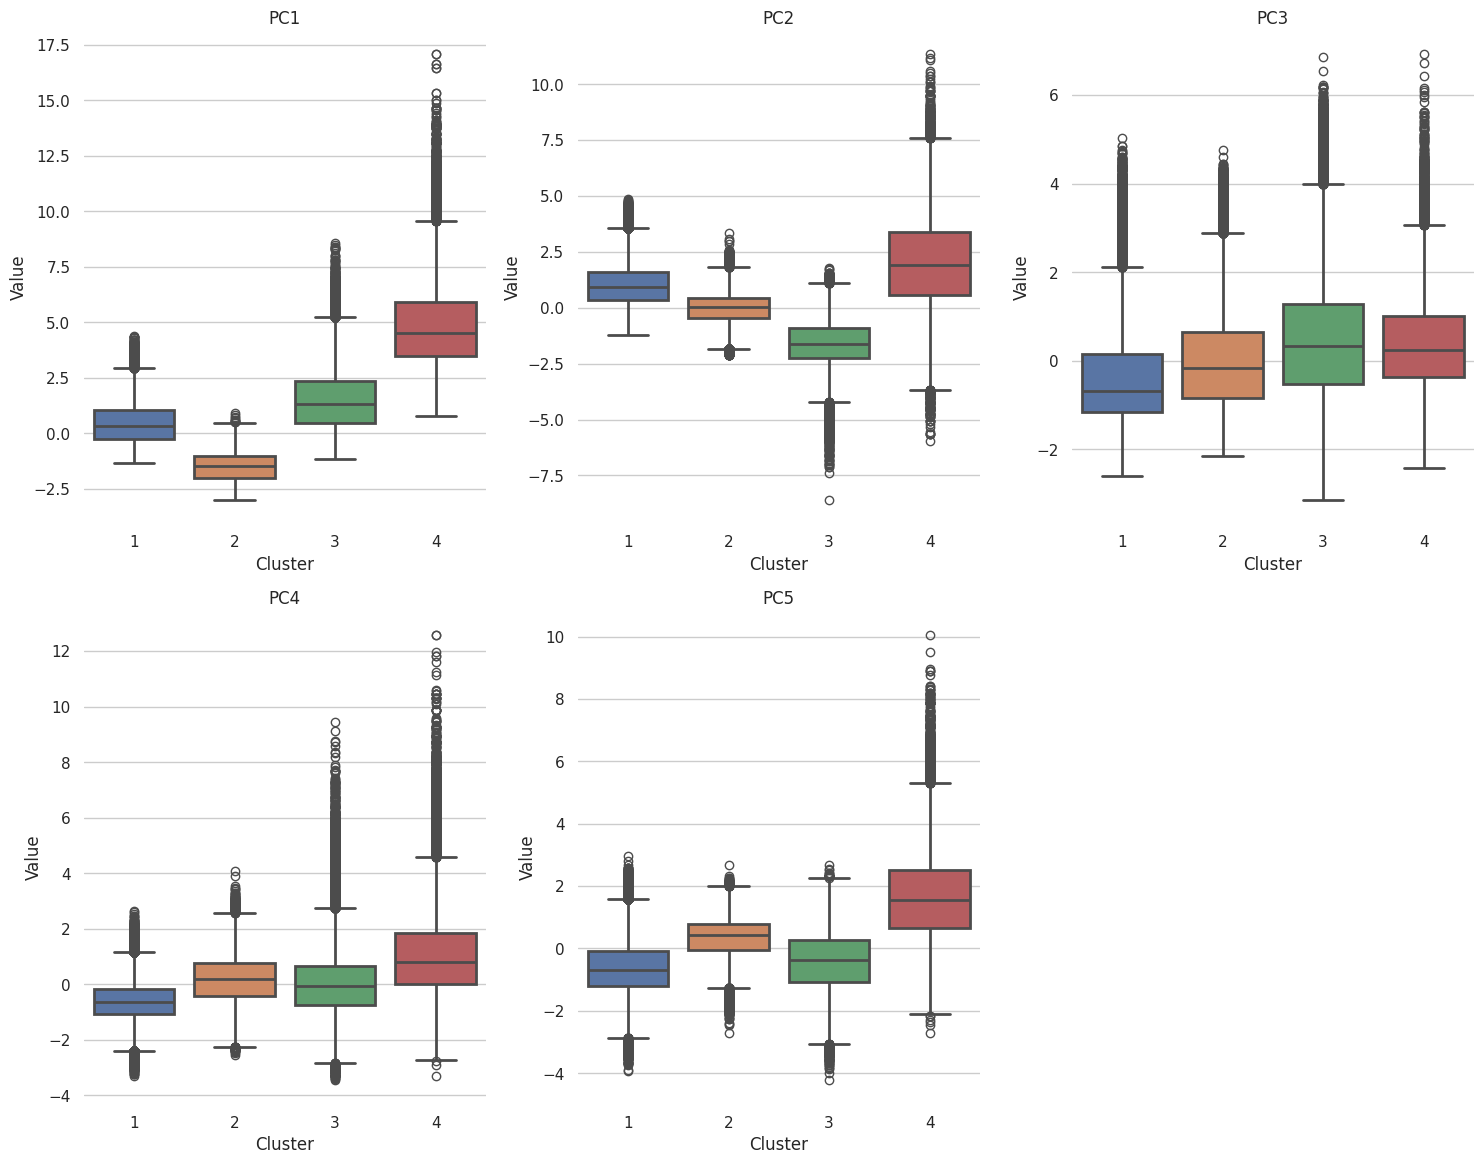

In [11]:
# Set the seaborn style for a minimal look
sns.set(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)})

# Define the principal components to plot
pcs = [f'PC{i+1}' for i in range(5)]

# Adjusting layout for 5 PCs with specified row settings
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

# Flatten axes array for easier indexing
axes = axes.flatten()

for i, pc in enumerate(pcs):
    sns.boxplot(x='cluster', y=pc, data=matched_data.assign(**{pc: X_pca[:, i]}), hue='cluster', palette=deep_colors_hex[:4], ax=axes[i], linewidth=2)
    axes[i].set_title(pc)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Value')
    axes[i].get_legend().remove()

    # Remove the outer spines for each subplot
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

The box plots reveal that the clusters differ significantly across the principal components. For instance:

*   **Cluster 1**: Mostly moderate values across all PCs, suggesting a 'typical' user group.
*   **Cluster 2**: Lower values for PC1 and PC2, indicating a distinct segment of users who may be less engaged or have different preferences.
*   **Cluster 3**: Lower values for PC2, PC4, PC5, but higher values for PC3, showing a complex pattern distinct from other clusters.
*   **Cluster 4**: Higher values for PC1 and PC5, suggesting a segment of users who are particularly responsive to certain features or aspects of the ad campaign.

## Cluster Profiling

Now, let's dive deeper into each cluster's profile by analyzing the percentage of exposed users, visit rates, and conversion rates within each group.

### Summary Statistics

In [12]:
# Summary statistics for each cluster
summary_stats = []

for cluster in sorted(matched_data['cluster'].unique()):
    cluster_data = matched_data[matched_data['cluster'] == cluster]
    total_count = len(cluster_data)
    exposed_count = cluster_data['exposure'].sum()
    exposure_percentage = exposed_count / total_count * 100

    visit_exposed_count = cluster_data[cluster_data['exposure'] == 1]['visit'].sum()
    visit_exposed_percentage = visit_exposed_count / exposed_count * 100 if exposed_count > 0 else 0

    conversion_exposed_count = cluster_data[cluster_data['exposure'] == 1]['conversion'].sum()
    conversion_exposed_percentage = conversion_exposed_count / exposed_count * 100 if exposed_count > 0 else 0

    conversion_visited_percentage = (conversion_exposed_count / visit_exposed_count * 100) if visit_exposed_count > 0 else 0

    summary_stats.append({
        'Cluster': cluster,
        'Total': total_count,
        'Exposed (%)': exposure_percentage,
        '% Visit | Exposed': visit_exposed_percentage,
        '% Conversion | Exposed': conversion_exposed_percentage,
        '% Conversion | Visited': conversion_visited_percentage
    })

summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df = summary_stats_df.sort_values(by='Cluster')

print(summary_stats_df.to_markdown(index=False, numalign='left', stralign='left'))

| Cluster   | Total   | Exposed (%)   | % Visit | Exposed   | % Conversion | Exposed   | % Conversion | Visited   |
|:----------|:--------|:--------------|:--------------------|:-------------------------|:-------------------------|
| 1         | 221380  | 48.8639       | 66.7853             | 7.15692                  | 10.7163                  |
| 2         | 400004  | 49.4005       | 20.8255             | 1.33854                  | 6.42739                  |
| 3         | 192131  | 51.4196       | 46.1834             | 3.69459                  | 7.99982                  |
| 4         | 42909   | 55.0933       | 78.2022             | 38.0457                  | 48.6504                  |


The summary statistics table paints a rich picture of the heterogeneity of treatment effects:

*   **Cluster 1**: This cluster exhibits a relatively balanced exposure rate (48.86%), but with notably high visit (66.79%) and conversion (7.16%) rates among the exposed users. This suggests that users in this cluster are generally receptive to the ad campaign, with a significant proportion converting after visiting the site.
*   **Cluster 2**: This cluster has a similar exposure rate (49.40%) but much lower visit and conversion rates (20.83% and 1.34% respectively). This group may represent users who are less likely to engage with the ad campaign or whose interests do not align well with the advertised product/service.
*   **Cluster 3**: Similar to cluster 1, this group shows moderate exposure (51.42%), but with higher visit (46.18%) and conversion (3.69%) rates among the exposed, suggesting some responsiveness to the campaign.
*   **Cluster 4**: This cluster stands out with the highest exposure rate (55.09%) and the highest visit and conversion rates among the exposed (78.20% and 38.05% respectively). This clearly identifies them as the most responsive segment to the ad campaign, warranting further investigation into their specific characteristics and preferences.

### Visualization Using Radar Charts

To complement the tabular summary, we can visualize the cluster profiles using radar charts, which offer a clear and intuitive way to compare multiple metrics across different groups.

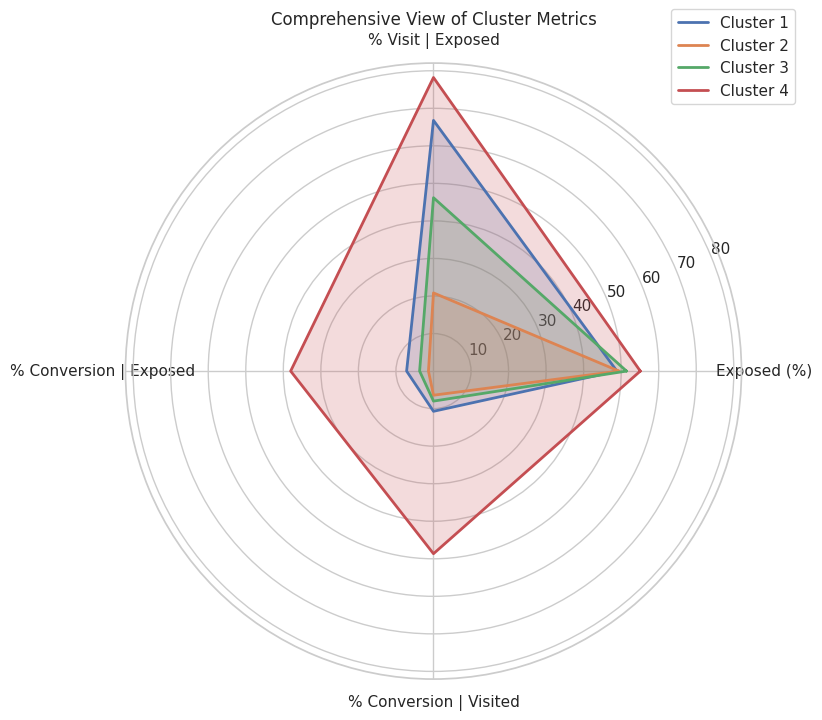

In [13]:
# Radar Chart for Comprehensive View
categories = ['Exposed (%)', '% Visit | Exposed', '% Conversion | Exposed', '% Conversion | Visited']
N = len(categories)

# What will be the angle of each axis in the plot
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in summary_stats_df.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {int(row["Cluster"])}', color=deep_colors_hex[i % len(deep_colors_hex)])
    ax.fill(angles, values, alpha=0.2)

# Customize the plot
ax.set_title('Comprehensive View of Cluster Metrics')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
legend.get_frame().set_facecolor('white')

plt.show()

The radar chart provides a clear visual representation of the distinct cluster profiles.

*   **Cluster 4**: This cluster clearly stands out as the most responsive segment, exhibiting the highest exposure rate, as well as the highest visit and conversion rates among exposed users. This indicates a strong positive response to the ad campaign within this group.
*   **Cluster 1**: While also showing a moderate exposure rate, this cluster exhibits high visit and conversion rates among exposed users, suggesting a good level of responsiveness to the campaign.
*   **Cluster 3**: This cluster shows a relatively lower exposure rate compared to clusters 1 and 4, with moderate visit and conversion rates. While not as responsive as the top two clusters, there might still be potential for improvement in targeting for this group.
*   **Cluster 2**: This cluster demonstrates the lowest engagement levels across all metrics, indicating a relatively low responsiveness to the ad campaign. This group might require a different approach or messaging in future campaigns.

## Logistic Regression and Bootstrapping

To estimate the causal effect of the ad campaign within each segment, we use logistic regression models incorporating the identified clusters and user features. This approach allows us to quantify the **average treatment effect on the treated (ATT)** specific to each cluster, providing insights into the heterogeneity of treatment effects.

In [14]:
def calculate_att_logistic(matched_data, features, outcome_col, cluster_col='cluster', bootstrap_samples=1000):
    # Create a formula for the logistic regression model
    formula = f'{outcome_col} ~ exposure + ' + ' + '.join(features) + f' + C({cluster_col}) + exposure:C({cluster_col})'

    # Print the formula
    print("Formula:", formula)

    # Fit the logistic regression model using the formula
    model = smf.logit(formula=formula, data=matched_data).fit(disp=0)

    # Predict probabilities for treated and their matched control
    treated = matched_data[matched_data['exposure'] == 1].copy()
    control = treated.copy()
    control['exposure'] = 0

    prob_treated = model.predict(treated)
    prob_control = model.predict(control)

    att = np.mean(prob_treated - prob_control)

    # Bootstrap for standard error estimation and confidence interval
    bootstrapped_atts = []
    for _ in range(bootstrap_samples):
        sample = resample(treated, replace=True)
        control_sample = sample.copy()
        control_sample['exposure'] = 0

        prob_treated_sample = model.predict(sample)
        prob_control_sample = model.predict(control_sample)

        bootstrapped_atts.append(np.mean(prob_treated_sample - prob_control_sample))

    std_error = np.std(bootstrapped_atts)
    ci_lower = att - 1.96 * std_error
    ci_upper = att + 1.96 * std_error

    return att, std_error, ci_lower, ci_upper, model

# Calculate and print ATT for 'visit' using logistic regression
att_visit_logistic, std_error_visit, ci_lower_visit, ci_upper_visit, visit_model = calculate_att_logistic(matched_data, features, 'visit')

# Calculate and print ATT for 'conversion' using logistic regression
att_conversion_logistic, std_error_conversion, ci_lower_conversion, ci_upper_conversion, conversion_model = calculate_att_logistic(matched_data, features, 'conversion')

print(f"ATT for visit (logistic): {att_visit_logistic:.4f} (SE: {std_error_visit:.4f}, 95% CI: [{ci_lower_visit:.4f}, {ci_upper_visit:.4f}])")
print(f"ATT for conversion (logistic): {att_conversion_logistic:.4f} (SE: {std_error_conversion:.4f}, 95% CI: [{ci_lower_conversion:.4f}, {ci_upper_conversion:.4f}])")

Formula: visit ~ exposure + f0 + f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10 + f11 + C(cluster) + exposure:C(cluster)
Formula: conversion ~ exposure + f0 + f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10 + f11 + C(cluster) + exposure:C(cluster)
ATT for visit (logistic): 0.2677 (SE: 0.0002, 95% CI: [0.2673, 0.2681])
ATT for conversion (logistic): 0.0424 (SE: 0.0001, 95% CI: [0.0422, 0.0426])


In [15]:
# Print the summary of the logistic regression model for 'visit'
print(visit_model.summary())

                           Logit Regression Results                           
Dep. Variable:                  visit   No. Observations:               856424
Model:                          Logit   Df Residuals:                   856404
Method:                           MLE   Df Model:                           19
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.3263
Time:                        22:48:47   Log-Likelihood:            -3.4494e+05
converged:                       True   LL-Null:                   -5.1199e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   78.9878      0.489    161.514      0.000      78.029      79.946
C(cluster)[T.2]             -0.3961      0.018    -22.131      0.000      -0.431      -0.

The logistic regression models quantify the causal impact of ad exposure on visits and conversions, revealing distinct heterogeneous effects across user segments. The coefficients of the interaction terms (`exposure:C(cluster)[T.2]`, `exposure:C(cluster)[T.3]`, `exposure:C(cluster)[T.4]`) represent the additional effect of the treatment for each cluster compared to the baseline cluster (Cluster 1).

### Visit Model:

*   **Overall ATT**: The average treatment effect on the treated (ATT) for visits is **0.2677** (SE: 0.0002, 95% CI: [0.2673, 0.2681]). This implies that, across all clusters, exposure to the ad campaign increases the probability of a user visiting the site by approximately 26.77 percentage points.

*   **Heterogeneous Effects by Cluster**:

  *   **Cluster 1 (Baseline)**: The estimated increase in visit probability for this cluster is the baseline ATT of 26.77 percentage points.
  *   **Cluster 2**: The positive and significant coefficient for `exposure:C(cluster)[T.2]` (0.4102) reveals that the treatment effect (increase in probability of visit due to ad exposure) is significantly stronger in Cluster 2 than in the baseline Cluster 1.
  *   **Cluster 3**: Similarly, the positive and significant coefficient for `exposure:C(cluster)[T.3]` (0.0782) indicates a stronger treatment effect in Cluster 3 compared to Cluster 1, although the magnitude of the difference is smaller than that observed in Cluster 2.
  *   **Cluster 4**: The negative but significant coefficient for `exposure:C(cluster)[T.4]` (-0.1755) suggests that the treatment effect is slightly weaker in Cluster 4 compared to the baseline Cluster 1. However, it's crucial to remember that the overall effect of ad exposure on visits for Cluster 4 remains positive because the baseline effect of exposure (1.9205) is much larger than this negative interaction term.

In [16]:
# Print the summary of the logistic regression model for 'conversion'
print(conversion_model.summary())

                           Logit Regression Results                           
Dep. Variable:             conversion   No. Observations:               856424
Model:                          Logit   Df Residuals:                   856404
Method:                           MLE   Df Model:                           19
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.3058
Time:                        22:48:50   Log-Likelihood:                -84729.
converged:                       True   LL-Null:                   -1.2206e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.4275      1.290      1.881      0.060      -0.101       4.956
C(cluster)[T.2]             -1.7066      0.106    -16.102      0.000      -1.914      -1.

### Conversion Model:

*   **Overall ATT**: The estimated ATT for conversions is **0.0424** (SE: 0.0001, 95% CI: [0.0422, 0.0426]). This means that, on average, exposure to the ad campaign increases the probability of conversion by approximately 4.24 percentage points across all clusters.

*   **Heterogeneous Effects by Cluster**:

  *   **Cluster 1 (Baseline)**: The estimated increase in conversion probability for this cluster aligns with the overall ATT of 4.24 percentage points.
  *   **Cluster 2**: Similar to the visit model, the treatment effect for conversions is significantly higher in Cluster 2 (1.1545) than in the baseline Cluster 1. This indicates that users in Cluster 2 are particularly responsive to the ad in terms of making a purchase.
  *   **Cluster 3**: The interaction term for Cluster 3 is not statistically significant (-0.0849, p = 0.144), suggesting that the ad campaign's effect on conversions in this cluster is not significantly different from the baseline.
  *   **Cluster 4**: This cluster experiences a decrease in the effect of ad exposure on conversion probability compared to the baseline (-0.4816). However, the overall effect remains positive due to the large baseline effect of exposure (2.1018).

## Key Insights

*   **Tailored Targeting**: Clusters 2 and 4 demonstrate the most distinctive responses to the ad campaign, highlighting the importance of tailoring advertising strategies to specific user segments.

*   **Cluster 2 Opportunities**: Cluster 2, while having a lower baseline conversion rate, exhibits a significant uplift in both visits and conversions when exposed to the ad. This suggests that focusing on this segment and understanding its unique characteristics could lead to substantial gains in conversions.

*   **Cluster 4 Refinement**: Cluster 4, while highly responsive overall, shows a slightly lower uplift in conversions compared to visits. This could indicate that while the ad is effective at attracting users from this cluster, further optimization of the conversion funnel may be necessary to maximize the impact.

## Conclusion:

In conclusion, this analysis demonstrates that the targeted ad campaign has a statistically significant positive impact on both user visits and conversions across all clusters, though the magnitude of these effects varies significantly across user segments. These findings highlight the importance of tailoring advertising strategies to specific user segments. Further investigation into the unique characteristics of each cluster can inform the development of more personalized and effective ad campaigns, ultimately maximizing the return on investment for future marketing initiatives.
